# LACE - Logic-Aware Consistency Evaluation

A comprehensive evaluation framework for measuring LLM logical consistency across semantic, formal, and knowledge-grounding dimensions.

## Overview

This notebook implements the LACE (Logic-Aware Consistency Evaluation) framework, which evaluates language models on six complementary metrics:

| Metric | Description | Dataset |
|--------|-------------|---------|
| EC | Entailment Classification | EntailmentBank |
| CR | Contradiction Rate | EntailmentBank |
| RS_F | Relational Structure (Formal) | RuleTaker |
| AC | Answer Consistency | RuleTaker |
| KAS | Knowledge Attribute Scoring | RuleTaker |
| RS_KG | Relational Structure (Knowledge Graph) | WebNLG |

The final **LCS (Logic Consistency Score)** is a weighted combination of these metrics.

## Key Features

- Increased sample sizes for better statistical significance
- Harder RuleTaker examples filtered by rule count
- Weighted LCS formula emphasizing discriminative metrics
- 4-bit quantization support for larger models
- CUDA-safe greedy decoding to avoid synchronization errors

## 1. Installation and Setup

Run the installation cell below, then restart the runtime before proceeding.

In [1]:
# =============================================================================
# LACE - Dependency Installation
# =============================================================================
# Install required packages for the evaluation framework.
# Run this cell once, then restart the runtime before proceeding.
#
# Package descriptions:
#   - datasets: HuggingFace datasets library for loading benchmark data
#   - transformers: Model loading and tokenization
#   - accelerate: Efficient model distribution across devices
#   - sentencepiece: Tokenizer backend for certain models
#   - bitsandbytes: 4-bit quantization support for large models
#   - tqdm: Progress bar visualization
#   - matplotlib/pandas: Results visualization and data handling
#   - numpy: Numerical computations
# =============================================================================

!pip install -q "datasets==2.19.1" "transformers>=4.40" accelerate sentencepiece bitsandbytes tqdm matplotlib pandas "numpy<2.0"

# Note: bitsandbytes enables 4-bit quantization for Phi-3-mini and Mistral-7B,
# allowing these larger models to run on consumer GPUs with limited VRAM.
# After installation completes, restart the runtime before running subsequent cells.


In [2]:
# =============================================================================
# Import Libraries and Configure Device
# =============================================================================
# This cell imports all required libraries and sets up the compute device.
# CUDA GPU is preferred for faster inference; CPU is used as fallback.
# =============================================================================

import gc
import re
import random
from collections import Counter
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# -----------------------------------------------------------------------------
# Clear any existing CUDA state to ensure clean memory allocation
# -----------------------------------------------------------------------------
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# -----------------------------------------------------------------------------
# Device Configuration
# Select GPU if available, otherwise fall back to CPU
# -----------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device Configuration")
print("-" * 40)
print(f"  Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    mem_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"  Memory: {mem_gb:.1f} GB")


Device Configuration
----------------------------------------
  Device: cuda
  GPU: NVIDIA A100-SXM4-40GB
  Memory: 42.5 GB


## 2. Configuration

Define evaluation parameters including models, sample sizes, and metric weights.

In [3]:
# =============================================================================
# Evaluation Configuration
# =============================================================================
# This dataclass contains all configurable parameters for the LACE evaluation.
# Modify these values to customize the evaluation behavior.
# =============================================================================


@dataclass
class LACEConfig:
    """
    Configuration settings for LACE (Logic-Aware Consistency Evaluation).

    This dataclass encapsulates all parameters needed to run the evaluation,
    including model selection, dataset sizes, generation parameters, and
    scoring weights.

    Attributes:
        models_to_test: List of HuggingFace model identifiers to evaluate.
        quantized_models: Subset of models requiring 4-bit quantization.
        nli_model: Model identifier for the NLI judge.
        num_samples: Number of samples for EntailmentBank and WebNLG.
        num_ruletaker_samples: Number of samples for RuleTaker dataset.
        min_ruletaker_rules: Minimum rules required for RuleTaker filtering.
        lcs_weights: Metric weights for computing the final LCS score.
        num_generations: Number of generations per prompt (for greedy).
        num_consistency_generations: Number of prompt variations for AC.
        max_new_tokens: Maximum tokens to generate per response.
        temperature: Sampling temperature (1.0 = deterministic).
        top_p: Nucleus sampling parameter.
        repetition_penalty: Penalty for repeated tokens.
        seed: Random seed for reproducibility.
    """

    # -------------------------------------------------------------------------
    # Model Configuration
    # -------------------------------------------------------------------------
    # List of models to evaluate, ordered by parameter count (ascending)
    models_to_test: List[str] = field(default_factory=lambda: [
        "Qwen/Qwen2.5-0.5B-Instruct",          # 0.5 billion parameters
        "Qwen/Qwen2.5-1.5B-Instruct",          # 1.5 billion parameters
        "microsoft/Phi-3-mini-4k-instruct",    # 3.8 billion parameters
        "mistralai/Mistral-7B-Instruct-v0.3",  # 7 billion parameters
    ])

    # Models that require 4-bit quantization to fit in GPU memory
    quantized_models: List[str] = field(default_factory=lambda: [
        "microsoft/Phi-3-mini-4k-instruct",
        "mistralai/Mistral-7B-Instruct-v0.3",
    ])

    # -------------------------------------------------------------------------
    # NLI Judge Configuration
    # -------------------------------------------------------------------------
    # RoBERTa-large fine-tuned on MNLI for entailment/contradiction detection
    nli_model: str = "roberta-large-mnli"

    # -------------------------------------------------------------------------
    # Dataset Configuration
    # -------------------------------------------------------------------------
    # Sample sizes chosen to balance statistical significance with runtime
    num_samples: int = 50                # EntailmentBank and WebNLG samples
    num_ruletaker_samples: int = 100     # RuleTaker samples (logic-focused)
    min_ruletaker_rules: int = 5         # Minimum rules for harder examples

    # -------------------------------------------------------------------------
    # LCS Weighting Configuration
    # -------------------------------------------------------------------------
    # Weights emphasize discriminative metrics (EC, RS_F, KAS) over
    # near-ceiling (AC) or near-floor (CR) metrics
    lcs_weights: Dict[str, float] = field(default_factory=lambda: {
        "ec": 2.0,      # Entailment Classification: highly discriminative
        "cr": 0.5,      # Contradiction Rate: near-floor, less informative
        "ac": 0.5,      # Answer Consistency: near-ceiling, less informative
        "rs_f": 2.0,    # Relational Structure (Formal): highly discriminative
        "rs_kg": 1.0,   # Knowledge Graph Relation: moderately discriminative
        "kas": 2.0,     # Counterfactual Sensitivity: highly discriminative
    })

    # -------------------------------------------------------------------------
    # Generation Parameters
    # -------------------------------------------------------------------------
    num_generations: int = 1             # Generations per prompt (greedy mode)
    num_consistency_generations: int = 4 # Prompt variations for AC metric
    max_new_tokens: int = 64             # Maximum response length

    # -------------------------------------------------------------------------
    # Sampling Parameters
    # -------------------------------------------------------------------------
    # Note: Sampling is disabled (temperature=1.0) for deterministic outputs
    # and to avoid CUDA synchronization errors with certain models
    temperature: float = 1.0
    top_p: float = 1.0
    repetition_penalty: float = 1.0

    # -------------------------------------------------------------------------
    # Reproducibility
    # -------------------------------------------------------------------------
    seed: int = 42


def set_seeds(seed: int) -> None:
    """
    Set random seeds for reproducibility across all libraries.

    Args:
        seed: Integer seed value for random number generators.

    Returns:
        None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# -----------------------------------------------------------------------------
# Initialize Configuration
# -----------------------------------------------------------------------------
CONFIG = LACEConfig()
set_seeds(CONFIG.seed)

# Display configuration summary
print("Configuration Loaded")
print("-" * 40)
print(f"  Models: {len(CONFIG.models_to_test)} models to evaluate")
for model in CONFIG.models_to_test:
    quant_tag = " (4-bit)" if model in CONFIG.quantized_models else ""
    print(f"    - {model}{quant_tag}")
print(f"  Samples: EntailmentBank/WebNLG={CONFIG.num_samples}, "
      f"RuleTaker={CONFIG.num_ruletaker_samples}")
print(f"  LCS Weights: {CONFIG.lcs_weights}")


Configuration Loaded
----------------------------------------
  Models: 4 models to evaluate
    - Qwen/Qwen2.5-0.5B-Instruct
    - Qwen/Qwen2.5-1.5B-Instruct
    - microsoft/Phi-3-mini-4k-instruct (4-bit)
    - mistralai/Mistral-7B-Instruct-v0.3 (4-bit)
  Samples: EntailmentBank/WebNLG=50, RuleTaker=100
  LCS Weights: {'ec': 2.0, 'cr': 0.5, 'ac': 0.5, 'rs_f': 2.0, 'rs_kg': 1.0, 'kas': 2.0}


## 3. Utility Functions

Text processing utilities and boolean extraction from model outputs.

In [4]:
# =============================================================================
# Text Processing and Boolean Extraction Utilities
# =============================================================================
# This module provides utility functions for:
#   1. Converting various data types to strings
#   2. Normalizing entity strings for comparison
#   3. Extracting boolean answers from model outputs
#   4. Creating counterfactual perturbations for sensitivity testing
# =============================================================================


# -----------------------------------------------------------------------------
# Text Conversion Utilities
# -----------------------------------------------------------------------------

def to_text(value: Any) -> str:
    """
    Convert various data types to a string representation.

    Handles None, lists, and other types gracefully. For lists, extracts
    the first element recursively.

    Args:
        value: Input value of any type (None, list, str, int, etc.).

    Returns:
        String representation of the input value.
        Returns empty string for None or empty lists.
    """
    if value is None:
        return ""
    if isinstance(value, list):
        return to_text(value[0]) if value else ""
    return str(value)


def normalize_entity(s: str) -> str:
    """
    Normalize entity strings for consistent matching.

    Applies the following transformations:
      1. Convert to lowercase
      2. Replace underscores with spaces
      3. Remove non-alphanumeric characters (except spaces)
      4. Collapse multiple spaces to single space

    Args:
        s: Input entity string to normalize.

    Returns:
        Normalized string suitable for comparison.
    """
    s = (s or "").lower().replace("_", " ")
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()


# -----------------------------------------------------------------------------
# Boolean Extraction from Model Outputs
# -----------------------------------------------------------------------------

# Pre-compiled regex patterns for efficient repeated matching
ANSWER_LINE_RE = re.compile(
    r"\b(?:final\s+answer|final|answer)\s*[:\-]\s*(true|false|yes|no)\b",
    flags=re.IGNORECASE
)
LAST_LINE_BOOL_RE = re.compile(
    r"^\s*(true|false|yes|no)\s*[\.!]*\s*$",
    flags=re.IGNORECASE
)
BOOL_TRUE_RE = re.compile(r"\b(true|yes)\b", flags=re.IGNORECASE)
BOOL_FALSE_RE = re.compile(r"\b(false|no)\b", flags=re.IGNORECASE)


def extract_final_boolean(text: str) -> Optional[bool]:
    """
    Extract the final boolean decision from model output text.

    Uses a priority-based extraction strategy:
      1. Look for explicit markers like "Answer: True" or "Final Answer: False"
      2. Check if the last line is a standalone boolean (True/False/Yes/No)
      3. Find the last occurrence of any boolean token in the text

    Args:
        text: Raw model output text to parse.

    Returns:
        Boolean value (True/False) if found, None if no boolean detected.
    """
    text = (text or "").strip()
    if not text:
        return None

    # Priority 1: Look for explicit answer markers (e.g., "Answer: True")
    matches = list(ANSWER_LINE_RE.finditer(text))
    if matches:
        last_match = matches[-1].group(1).lower()
        return last_match in ("true", "yes")

    # Priority 2: Check if last non-empty line is a pure boolean value
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    if lines:
        match = LAST_LINE_BOOL_RE.match(lines[-1])
        if match:
            return match.group(1).lower() in ("true", "yes")

    # Priority 3: Find last occurrence of any boolean token
    true_positions = [m.start() for m in BOOL_TRUE_RE.finditer(text)]
    false_positions = [m.start() for m in BOOL_FALSE_RE.finditer(text)]

    if not true_positions and not false_positions:
        return None

    last_true = true_positions[-1] if true_positions else -1
    last_false = false_positions[-1] if false_positions else -1
    return last_true > last_false


def normalize_ruletaker_label(label: Any) -> bool:
    """
    Convert RuleTaker dataset labels to boolean values.

    Handles various label formats used in the dataset:
      - Boolean values (True/False)
      - Integer values (0/1)
      - String values ("true", "false", "yes", "no", "entails", etc.)

    Args:
        label: Raw label value from RuleTaker dataset.

    Returns:
        Boolean interpretation of the label. Defaults to False for
        unrecognized formats.
    """
    if isinstance(label, bool):
        return label
    if isinstance(label, (int, np.integer)):
        return bool(label)
    if isinstance(label, str):
        s = label.strip().lower()
        if s in {"true", "yes", "1", "entails", "entailed"}:
            return True
    return False


# -----------------------------------------------------------------------------
# Counterfactual Perturbation for Sensitivity Testing
# -----------------------------------------------------------------------------

def perturb_context(context: str) -> str:
    """
    Create a counterfactual version of context by negating statements.

    Used for the Knowledge Attribute Scoring (KAS) metric to test whether
    models appropriately change their answers when premises are negated.

    Transformation: Prepends "It is not the case that" to each sentence
    (unless already negated).

    Args:
        context: Original context string containing logical statements.

    Returns:
        Modified context with all statements negated.
    """
    context = (context or "").strip()
    if not context:
        return ""

    # Split context into individual sentences/statements
    parts = [p.strip() for p in re.split(r"(?<=[.?!])\s+|\n+", context) if p.strip()]
    negated = []

    for part in parts:
        # Avoid double negation
        if part.lower().startswith("it is not the case that"):
            negated.append(part)
        else:
            negated.append(f"It is not the case that {part}")

    return " ".join(negated)


print("Utility functions loaded successfully")


Utility functions loaded successfully


## 4. NLI Judge

Natural Language Inference model for entailment and contradiction detection.

In [5]:
# =============================================================================
# Natural Language Inference (NLI) Judge
# =============================================================================
# The NLI Judge uses a pre-trained RoBERTa model fine-tuned on the MultiNLI
# dataset to classify premise-hypothesis pairs as:
#   - "entailment": hypothesis follows from premise
#   - "neutral": hypothesis is neither supported nor contradicted
#   - "contradiction": hypothesis contradicts the premise
#
# This is used for:
#   - EC (Entailment Classification): Check if model output entails gold answer
#   - CR (Contradiction Rate): Check if output contradicts the context
#   - RS_KG: Check if generated text entails knowledge graph triples
# =============================================================================


class NLIJudge:
    """
    Wrapper class for Natural Language Inference classification.

    Encapsulates a pre-trained sequence classification model for predicting
    textual entailment relationships between premise-hypothesis pairs.

    Attributes:
        tokenizer: HuggingFace tokenizer for the NLI model.
        model: Pre-trained sequence classification model.
        id2label: Mapping from prediction indices to label strings.
    """

    def __init__(self, model_name: str = "roberta-large-mnli"):
        """
        Initialize the NLI Judge with a pre-trained model.

        Args:
            model_name: HuggingFace model identifier for the NLI model.
                       Default is RoBERTa-large fine-tuned on MNLI.

        Returns:
            None
        """
        print(f"Loading NLI Judge: {model_name}")

        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name
        ).to(DEVICE)
        self.model.eval()

        # Extract label mapping from model configuration
        self.id2label = {
            int(k): v.lower()
            for k, v in self.model.config.id2label.items()
        }

        print("NLI Judge ready")

    @torch.no_grad()
    def predict_labels(
        self,
        pairs: List[Tuple[str, str]],
        batch_size: int = 16
    ) -> List[str]:
        """
        Predict NLI labels for a list of premise-hypothesis pairs.

        Processes pairs in batches for efficiency. Each pair is classified
        as "entailment", "neutral", or "contradiction".

        Args:
            pairs: List of (premise, hypothesis) tuples to classify.
            batch_size: Number of pairs to process per batch.

        Returns:
            List of label strings corresponding to each input pair.
        """
        labels = []

        for start in range(0, len(pairs), batch_size):
            # Extract current batch
            batch = pairs[start:start + batch_size]

            # Convert all inputs to strings
            batch = [(to_text(p), to_text(h)) for p, h in batch]

            # Tokenize batch
            inputs = self.tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(DEVICE)

            # Forward pass and get predictions
            logits = self.model(**inputs).logits
            preds = torch.argmax(logits, dim=-1)

            # Convert prediction indices to label strings
            labels.extend([self.id2label[int(p.item())] for p in preds])

        return labels

    def cleanup(self) -> None:
        """
        Release GPU memory by deleting model and tokenizer.

        Should be called when the NLI Judge is no longer needed to free
        up GPU memory for other models.

        Returns:
            None
        """
        del self.model
        del self.tokenizer
        torch.cuda.empty_cache()
        gc.collect()


# -----------------------------------------------------------------------------
# Initialize the NLI Judge
# -----------------------------------------------------------------------------
nli_judge = NLIJudge(CONFIG.nli_model)


Loading NLI Judge: roberta-large-mnli


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NLI Judge ready


## 5. Candidate LLM Wrapper

Model wrapper with 4-bit quantization support for memory-efficient inference.

In [6]:
# =============================================================================
# Candidate Language Model Wrapper
# =============================================================================
# This class wraps HuggingFace causal language models for evaluation.
# Key features:
#   - Automatic 4-bit quantization for large models (via bitsandbytes)
#   - Chat template formatting when available
#   - Greedy decoding for deterministic outputs
#   - Special handling for Phi-3 models (cache disabled to avoid errors)
# =============================================================================


class CandidateLLM:
    """
    Wrapper for causal language models with quantization support.

    Provides a unified interface for loading and generating text from
    various HuggingFace causal language models. Supports 4-bit quantization
    to enable running larger models on limited GPU memory.

    Attributes:
        model_name: HuggingFace model identifier.
        tokenizer: Tokenizer instance for the model.
        model: The loaded language model.
    """

    def __init__(self, model_name: str, quantize: bool = False):
        """
        Initialize and load a causal language model.

        Args:
            model_name: HuggingFace model identifier to load.
            quantize: If True, apply 4-bit quantization using bitsandbytes.
                     Required for larger models (>3B params) on consumer GPUs.

        Returns:
            None
        """
        from transformers import BitsAndBytesConfig

        quant_str = " (4-bit quantized)" if quantize else ""
        print(f"Loading model: {model_name}{quant_str}")
        self.model_name = model_name

        # Load tokenizer with trust_remote_code for custom models
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=True,
        )

        # Ensure pad token is set (required for batch generation)
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        # Configure model loading parameters
        model_kwargs = {
            "trust_remote_code": True,
            "low_cpu_mem_usage": True,
        }

        if quantize and DEVICE.type == "cuda":
            # Configure 4-bit quantization using bitsandbytes
            # NF4 (Normal Float 4) provides good quality with 4-bit weights
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,  # Further compression
            )
            model_kwargs["quantization_config"] = bnb_config
            model_kwargs["device_map"] = "auto"
        else:
            # Standard loading with fp16 on GPU, fp32 on CPU
            if DEVICE.type == "cuda":
                model_kwargs["torch_dtype"] = torch.float16
                model_kwargs["device_map"] = "auto"
            else:
                model_kwargs["torch_dtype"] = torch.float32

        # Load the model
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            **model_kwargs
        )
        self.model.eval()
        print(f"Model ready: {model_name}")

    def _format_prompt(self, prompt: str) -> str:
        """
        Format prompt using the model's chat template if available.

        Many instruction-tuned models expect a specific prompt format.
        This method applies the chat template when available.

        Args:
            prompt: Raw user prompt text.

        Returns:
            Formatted prompt string ready for generation.
        """
        # Check if model has a chat template
        if hasattr(self.tokenizer, "apply_chat_template") and \
           getattr(self.tokenizer, "chat_template", None):
            try:
                return self.tokenizer.apply_chat_template(
                    [{"role": "user", "content": prompt}],
                    tokenize=False,
                    add_generation_prompt=True
                )
            except Exception:
                pass  # Fall back to raw prompt
        return prompt

    @torch.no_grad()
    def generate(
        self,
        prompt: str,
        n: int = 1,
        do_sample: bool = False,
        max_new_tokens: int = 64,
        **kwargs
    ) -> List[str]:
        """
        Generate text completions for a given prompt.

        Uses greedy decoding by default for deterministic outputs.
        The do_sample parameter is ignored (always False) to avoid
        CUDA synchronization errors with certain models.

        Args:
            prompt: Input text to complete.
            n: Number of completions to generate.
            do_sample: Ignored - always uses greedy decoding.
            max_new_tokens: Maximum number of tokens to generate.
            **kwargs: Additional arguments (currently unused).

        Returns:
            List of generated text completions (length n).
        """
        # Apply chat template formatting
        prompt = self._format_prompt(prompt)

        # Tokenize input
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=1024,
        ).to(self.model.device)

        # Phi-3 models have cache compatibility issues; disable cache
        use_cache_setting = True
        if "Phi-3" in self.model_name or "phi-3" in self.model_name.lower():
            use_cache_setting = False

        results = []
        for _ in range(n):
            try:
                # Generate with greedy decoding (do_sample=False always)
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,  # Greedy decoding for stability
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    use_cache=use_cache_setting,
                )

                # Decode only the generated portion (exclude input)
                generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
                text = self.tokenizer.decode(
                    generated_ids,
                    skip_special_tokens=True,
                ).strip()
                results.append(text)

            except Exception as e:
                print(f"   Generation error: {str(e)[:50]}")
                results.append("")

        return results

    def cleanup(self) -> None:
        """
        Release GPU memory by deleting model and tokenizer.

        Should be called after evaluation of each model to free memory
        before loading the next model.

        Returns:
            None
        """
        del self.model
        del self.tokenizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()


print("CandidateLLM class defined (with 4-bit quantization support)")


CandidateLLM class defined (with 4-bit quantization support)


## 6. Dataset Loading

Load and preprocess the three benchmark datasets.

In [7]:
# =============================================================================
# Dataset Loading and Preprocessing
# =============================================================================
# This module handles loading the three benchmark datasets:
#   1. EntailmentBank: Science QA with reasoning chains
#   2. RuleTaker: Synthetic logical reasoning problems
#   3. WebNLG: Knowledge graph to text generation
#
# RuleTaker filtering selects harder examples with more rules to better
# discriminate between models of different capabilities.
# =============================================================================


def try_load(
    name: str,
    config: Optional[str] = None,
    split: Optional[str] = None
) -> Optional[Any]:
    """
    Attempt to load a HuggingFace dataset with error handling.

    Provides a safe wrapper around load_dataset that catches exceptions
    and returns None on failure, allowing fallback loading strategies.

    Args:
        name: HuggingFace dataset identifier (e.g., "suzakuteam/entailment_bank").
        config: Optional dataset configuration name.
        split: Optional dataset split (e.g., "train", "test").

    Returns:
        Loaded dataset if successful, None if loading failed.
    """
    try:
        if config is None and split is None:
            return load_dataset(name, trust_remote_code=True)
        if config is None:
            return load_dataset(name, split=split, trust_remote_code=True)
        return load_dataset(name, config, split=split, trust_remote_code=True)
    except Exception as e:
        print(f"[LOAD FAILED] {name} | config={config} | split={split}")
        print(f"  Error: {e}")
        return None


def count_rules_in_context(context: str) -> int:
    """
    Count the number of rules/facts in a RuleTaker context string.

    Uses heuristics to estimate complexity:
      - Counts sentence-ending punctuation followed by whitespace
      - Counts "If" statements which indicate conditional rules

    Args:
        context: The context string from a RuleTaker example.

    Returns:
        Estimated number of rules/facts in the context.
    """
    if not context:
        return 0

    # Count sentences (periods, exclamation marks, question marks)
    sentences = len(re.findall(r'[.!?]+\s+|[.!?]+$', context))

    # Count explicit conditional rules ("If X then Y")
    rules = len(re.findall(r'\bIf\s+', context, re.IGNORECASE))

    return max(sentences, rules)


def filter_hard_ruletaker(
    dataset: Any,
    min_rules: int = 5,
    max_samples: int = 100
) -> Any:
    """
    Filter RuleTaker dataset for harder examples with more rules.

    Examples with more rules require longer reasoning chains, which
    better discriminates between models of different capabilities.

    Args:
        dataset: Full RuleTaker dataset to filter.
        min_rules: Minimum number of rules required (default: 5).
        max_samples: Maximum number of samples to return (default: 100).

    Returns:
        Filtered dataset containing only harder examples.
    """
    hard_indices = []

    # Scan dataset for examples meeting the difficulty threshold
    for i, ex in enumerate(dataset):
        ctx = to_text(ex.get("context", ""))
        num_rules = count_rules_in_context(ctx)

        if num_rules >= min_rules:
            hard_indices.append(i)

        # Early stopping if we have enough candidates
        if len(hard_indices) >= max_samples * 2:
            break

    # Handle case where no examples meet the threshold
    if len(hard_indices) == 0:
        print(f"Warning: No examples with >= {min_rules} rules found")
        print("  Falling back to sequential selection")
        return dataset.select(range(min(max_samples, len(dataset))))

    # Randomly sample from qualified examples for variety
    random.shuffle(hard_indices)
    selected = hard_indices[:max_samples]

    print(f"Filtered RuleTaker: {len(selected)} hard examples "
          f"(>= {min_rules} rules each)")

    return dataset.select(selected)


def load_datasets(cfg: LACEConfig) -> Tuple[Any, Any, Any]:
    """
    Load all three benchmark datasets for LACE evaluation.

    Loads and preprocesses:
      - EntailmentBank: Science QA with explanation chains
      - RuleTaker: Logical reasoning (filtered for harder examples)
      - WebNLG: Knowledge graph verbalization

    Args:
        cfg: LACEConfig instance containing dataset size parameters.

    Returns:
        Tuple of (entailmentbank_subset, ruletaker_subset, webnlg_subset).
        Any subset may be None if loading failed.
    """
    subset_eb = subset_rt = subset_wn = None

    # -------------------------------------------------------------------------
    # Load EntailmentBank
    # -------------------------------------------------------------------------
    print("Loading EntailmentBank...")
    eb = (
        try_load("suzakuteam/entailment_bank", config="default", split="train")
        or try_load("suzakuteam/entailment_bank", config=None, split="train")
    )
    if eb is not None:
        subset_eb = eb.select(range(min(cfg.num_samples, len(eb))))
        print(f"  EntailmentBank: {len(subset_eb)} samples loaded")

    # -------------------------------------------------------------------------
    # Load RuleTaker (with difficulty filtering)
    # -------------------------------------------------------------------------
    print("Loading RuleTaker...")
    rt = try_load("tasksource/ruletaker", config=None, split="test")
    if rt is not None:
        subset_rt = filter_hard_ruletaker(
            rt,
            min_rules=cfg.min_ruletaker_rules,
            max_samples=cfg.num_ruletaker_samples
        )
        print(f"  RuleTaker: {len(subset_rt)} hard samples loaded")

    # -------------------------------------------------------------------------
    # Load WebNLG
    # -------------------------------------------------------------------------
    print("Loading WebNLG...")
    wn = (
        try_load("GEM/web_nlg", config="en", split="test")
        or try_load("GEM/web_nlg", config=None, split="test")
    )
    if wn is not None:
        subset_wn = wn.select(range(min(cfg.num_samples, len(wn))))
        print(f"  WebNLG: {len(subset_wn)} samples loaded")

    return subset_eb, subset_rt, subset_wn


# =============================================================================
# Dataset Field Extraction Helpers
# =============================================================================
# These functions extract specific fields from dataset examples,
# handling variations in field names across different dataset versions.
# =============================================================================


def get_eb_question(ex: Dict[str, Any]) -> str:
    """
    Extract the question from an EntailmentBank example.

    Args:
        ex: Dictionary containing the dataset example.

    Returns:
        Question string, or empty string if not found.
    """
    for key in ["question", "query", "prompt", "input"]:
        if key in ex and to_text(ex[key]).strip():
            return to_text(ex[key]).strip()
    return ""


def get_eb_gold(ex: Dict[str, Any]) -> str:
    """
    Extract the gold answer from an EntailmentBank example.

    Args:
        ex: Dictionary containing the dataset example.

    Returns:
        Gold answer string, or empty string if not found.
    """
    for key in ["answer", "gold_answer", "output", "label", "target"]:
        if key in ex and to_text(ex[key]).strip():
            return to_text(ex[key]).strip()
    return ""


def get_eb_context(ex: Dict[str, Any]) -> str:
    """
    Extract the context/premises from an EntailmentBank example.

    Args:
        ex: Dictionary containing the dataset example.

    Returns:
        Context string, or empty string if not found.
    """
    for key in ["context", "premises", "premise", "facts", "supporting_facts"]:
        if key not in ex:
            continue
        v = ex.get(key)
        if isinstance(v, list):
            txt = "\n".join(to_text(x) for x in v).strip()
        else:
            txt = to_text(v).strip()
        if txt:
            return txt
    return ""


def get_rt_gold(ex: Dict[str, Any]) -> Optional[Any]:
    """
    Extract the gold label from a RuleTaker example.

    Args:
        ex: Dictionary containing the dataset example.

    Returns:
        Gold label value, or None if not found.
    """
    for key in ["label", "answer", "gold", "target"]:
        if key in ex and ex[key] is not None:
            return ex[key]
    return None


def get_wn_triples(ex: Dict[str, Any]) -> List[str]:
    """
    Extract knowledge graph triples from a WebNLG example.

    Handles the GEM/web_nlg format where triples may be stored
    in various fields as lists or newline-separated strings.

    Args:
        ex: Dictionary containing the dataset example.

    Returns:
        List of triple strings in "subject | predicate | object" format.
    """
    for key in ["input", "triples", "mr", "source"]:
        if key not in ex:
            continue
        v = ex[key]
        if isinstance(v, list):
            return [to_text(x).strip() for x in v if to_text(x).strip()]
        if isinstance(v, str) and v.strip():
            return [s.strip() for s in v.splitlines() if s.strip()]
    return []


# =============================================================================
# Load Datasets
# =============================================================================
print("")
print("=" * 60)
print("Loading Datasets")
print("=" * 60)
subset_eb, subset_rt, subset_wn = load_datasets(CONFIG)



Loading Datasets
Loading EntailmentBank...


Generating train split:   0%|          | 0/1840 [00:00<?, ? examples/s]

  EntailmentBank: 50 samples loaded
Loading RuleTaker...


Generating train split:   0%|          | 0/480152 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/151911 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/75872 [00:00<?, ? examples/s]

Filtered RuleTaker: 100 hard examples (>= 5 rules each)
  RuleTaker: 100 hard samples loaded
Loading WebNLG...


Generating train split:   0%|          | 0/35426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1667 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1779 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/502 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/499 [00:00<?, ? examples/s]

Generating challenge_test_scramble split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_numbers split:   0%|          | 0/500 [00:00<?, ? examples/s]

  WebNLG: 50 samples loaded


## 7. Scoring Functions

Implementation of the six LACE metrics and the final LCS computation.

In [8]:
# =============================================================================
# Metric Scoring Functions
# =============================================================================
# This module implements the six LACE metrics:
#
# EntailmentBank metrics:
#   - EC (Entailment Classification): Does output entail the gold answer?
#   - CR (Contradiction Rate): Does output contradict the context?
#
# RuleTaker metrics:
#   - RS_F (Relational Structure - Formal): Logical reasoning accuracy
#   - AC (Answer Consistency): Self-consistency across prompt variations
#   - KAS (Knowledge Attribute Scoring): Sensitivity to counterfactuals
#
# WebNLG metric:
#   - RS_KG (Relational Structure - KG): Knowledge graph verbalization
#
# Final score:
#   - LCS (Logic Consistency Score): Weighted combination of all metrics
# =============================================================================


def score_entailmentbank(
    llm: CandidateLLM,
    subset: Any,
    nli_judge: NLIJudge,
    config: LACEConfig
) -> Tuple[float, float]:
    """
    Compute EC and CR metrics on EntailmentBank dataset.

    EC (Entailment Classification): Measures whether the model's response
    semantically entails the gold answer.

    CR (Contradiction Rate): Measures how often the model's response
    contradicts the given context/premises.

    Args:
        llm: The candidate language model to evaluate.
        subset: EntailmentBank dataset subset.
        nli_judge: NLI model for entailment classification.
        config: Configuration containing generation parameters.

    Returns:
        Tuple of (EC_score, CR_score) as floats in range [0, 1].
    """
    if subset is None or len(subset) == 0 or nli_judge is None:
        return 0.0, 0.0

    ec_vals = []  # Entailment scores
    cr_vals = []  # Contradiction scores

    for ex in tqdm(subset, desc="EntailmentBank", leave=False):
        question = get_eb_question(ex)
        gold_answer = get_eb_gold(ex)
        context = get_eb_context(ex) or question

        if not question:
            continue

        try:
            # Generate model response
            response = llm.generate(
                f"Question: {question}\nAnswer:",
                n=1,
                do_sample=False,
                max_new_tokens=config.max_new_tokens
            )[0]

            if not response.strip():
                continue

            # EC: Check if response entails gold answer
            ec_label = nli_judge.predict_labels([(response, gold_answer)])[0]
            ec_vals.append(1.0 if ec_label == "entailment" else 0.0)

            # CR: Check if context contradicts response
            cr_label = nli_judge.predict_labels([(context, response)])[0]
            cr_vals.append(1.0 if cr_label == "contradiction" else 0.0)

        except Exception as e:
            print(f"      EntailmentBank error: {e}")
            continue

    # Compute mean scores
    ec_score = float(np.mean(ec_vals)) if ec_vals else 0.0
    cr_score = float(np.mean(cr_vals)) if cr_vals else 0.0

    return ec_score, cr_score


def score_ruletaker(
    llm: CandidateLLM,
    subset: Any,
    config: LACEConfig
) -> Tuple[float, float, float]:
    """
    Compute RS_F, AC, and KAS metrics on RuleTaker dataset.

    RS_F (Relational Structure - Formal): Accuracy of logical reasoning.
    Measures whether the model correctly applies logical rules.

    AC (Answer Consistency): Self-consistency across prompt variations.
    Higher scores indicate the model gives consistent answers.

    KAS (Knowledge Attribute Scoring): Sensitivity to counterfactuals.
    Measures whether the model changes its answer when premises are negated.

    Args:
        llm: The candidate language model to evaluate.
        subset: RuleTaker dataset subset.
        config: Configuration containing generation parameters.

    Returns:
        Tuple of (RS_F_score, AC_score, KAS_score) as floats in range [0, 1].
    """
    if subset is None or len(subset) == 0:
        return 0.0, 0.0, 0.0

    rsf_vals = []  # Formal reasoning accuracy
    ac_vals = []   # Answer consistency
    kas_vals = []  # Counterfactual sensitivity

    # Instruction for boolean question answering
    instruction = "Reply with exactly: Answer: True OR Answer: False\n"

    for ex in tqdm(subset, desc="RuleTaker", leave=False):
        context = to_text(ex.get("context"))
        question = to_text(ex.get("question"))
        expected = normalize_ruletaker_label(get_rt_gold(ex))

        prompt = f"{context}\nQuestion: {question}\n{instruction}"

        try:
            # -----------------------------------------------------------------
            # RS_F: Greedy generation for accuracy
            # -----------------------------------------------------------------
            response = llm.generate(
                prompt,
                n=1,
                do_sample=False,
                max_new_tokens=32
            )[0]
            predicted = extract_final_boolean(response)

            # Score: 1 if prediction matches expected, 0 otherwise
            rsf_score = 1.0 if (predicted is not None and
                                predicted == expected) else 0.0
            rsf_vals.append(rsf_score)

            # -----------------------------------------------------------------
            # KAS: Counterfactual sensitivity
            # -----------------------------------------------------------------
            # Create negated version of context
            counterfactual_prompt = (
                f"{perturb_context(context)}\n"
                f"Question: {question}\n{instruction}"
            )
            cf_response = llm.generate(
                counterfactual_prompt,
                n=1,
                do_sample=False,
                max_new_tokens=32
            )[0]
            cf_predicted = extract_final_boolean(cf_response)

            # Score: 1 if answer changed (model is sensitive), 0 otherwise
            kas_score = 1.0 if (predicted is not None and
                                cf_predicted is not None and
                                predicted != cf_predicted) else 0.0
            kas_vals.append(kas_score)

            # -----------------------------------------------------------------
            # AC: Answer consistency across prompt variations
            # -----------------------------------------------------------------
            # Use different prompt phrasings to test consistency
            prompt_variations = [
                prompt,
                f"Context: {context}\nQ: {question}\n{instruction}",
                f"{context}\n\nQuestion: {question}\n{instruction}",
            ]

            votes = []
            for prompt_var in prompt_variations[:config.num_consistency_generations]:
                try:
                    var_response = llm.generate(
                        prompt_var,
                        n=1,
                        do_sample=False,
                        max_new_tokens=32
                    )[0]
                    vote = extract_final_boolean(var_response)
                    if vote is not None:
                        votes.append(vote)
                except Exception:
                    pass

            # AC score: fraction of votes matching the majority
            if votes:
                vote_counts = Counter(votes)
                ac_score = max(vote_counts.values()) / len(votes)
            else:
                ac_score = 0.0
            ac_vals.append(ac_score)

        except Exception as e:
            print(f"      RuleTaker error: {e}")
            continue

    # Compute mean scores
    rsf_score = float(np.mean(rsf_vals)) if rsf_vals else 0.0
    ac_score = float(np.mean(ac_vals)) if ac_vals else 0.0
    kas_score = float(np.mean(kas_vals)) if kas_vals else 0.0

    return rsf_score, ac_score, kas_score


def score_webnlg(
    llm: CandidateLLM,
    subset: Any,
    nli_judge: NLIJudge
) -> float:
    """
    Compute RS_KG metric on WebNLG dataset.

    RS_KG (Relational Structure - Knowledge Graph): Measures how well
    the model verbalizes knowledge graph triples. Uses NLI to check
    if the generated sentence entails each input triple.

    Args:
        llm: The candidate language model to evaluate.
        subset: WebNLG dataset subset.
        nli_judge: NLI model for entailment checking.

    Returns:
        RS_KG score as float in range [0, 1].
    """
    if subset is None or len(subset) == 0:
        return 0.0

    rs_vals = []

    def humanize_relation(rel: str) -> str:
        """Convert camelCase or snake_case relation to readable text."""
        rel = (rel or "").replace("_", " ").strip()
        # Insert space before capitals (camelCase to words)
        rel = re.sub(r"([a-z])([A-Z])", r"\1 \2", rel)
        return re.sub(r"\s+", " ", rel).strip()

    def triple_to_hypothesis(triple: str) -> str:
        """Convert a triple string to a natural language hypothesis."""
        parts = [p.strip() for p in to_text(triple).split("|")]
        if len(parts) >= 3:
            subject = parts[0]
            predicate = humanize_relation(parts[1])
            obj = parts[2]
            return f"{subject} {predicate} {obj}."
        return to_text(triple).strip()

    for ex in tqdm(subset, desc="WebNLG", leave=False):
        triples = get_wn_triples(ex)
        if not triples:
            continue

        try:
            # Create prompt for triple verbalization
            prompt = (
                "Convert these facts into ONE sentence.\n"
                f"{chr(10).join(triples)}\n"
                "Sentence:"
            )

            # Generate verbalization
            output = llm.generate(
                prompt,
                n=1,
                do_sample=False,
                max_new_tokens=100
            )[0]

            if not output.strip():
                rs_vals.append(0.0)
                continue

            # Check if output entails each triple using NLI
            if nli_judge:
                hypotheses = [triple_to_hypothesis(t) for t in triples]
                pairs = [(output, h) for h in hypotheses if h]

                if pairs:
                    labels = nli_judge.predict_labels(pairs)
                    # RS_KG: fraction of triples entailed by output
                    entailed_count = sum(1 for l in labels if l == "entailment")
                    rs_kg = entailed_count / len(pairs)
                else:
                    rs_kg = 0.0
            else:
                # Fallback: lexical overlap check
                output_normalized = normalize_entity(output)
                hits = sum(
                    1 for t in triples
                    if len(t.split("|")) >= 3 and
                    normalize_entity(t.split("|")[0]) in output_normalized and
                    normalize_entity(t.split("|")[2]) in output_normalized
                )
                rs_kg = hits / max(1, len(triples))

            rs_vals.append(rs_kg)

        except Exception as e:
            print(f"      WebNLG error: {e}")
            continue

    return float(np.mean(rs_vals)) if rs_vals else 0.0


def compute_lcs(
    ec: float,
    cr: float,
    rs_f: float,
    rs_kg: float,
    kas: float,
    ac: float,
    weights: Optional[Dict[str, float]] = None
) -> float:
    """
    Compute the Logic Consistency Score (LCS) from individual metrics.

    LCS is a weighted combination of all six metrics, designed to provide
    a single summary score for model logical consistency.

    Note: CR (contradiction rate) is inverted since lower is better.

    Args:
        ec: Entailment Classification score [0, 1].
        cr: Contradiction Rate [0, 1] (will be inverted to 1-cr).
        rs_f: Relational Structure - Formal score [0, 1].
        rs_kg: Relational Structure - KG score [0, 1].
        kas: Knowledge Attribute Scoring [0, 1].
        ac: Answer Consistency score [0, 1].
        weights: Optional dictionary mapping metric names to weights.
                 Keys: 'ec', 'cr', 'ac', 'rs_f', 'rs_kg', 'kas'.
                 If None, uses equal weights.

    Returns:
        LCS score as float in range [0, 1].
    """
    if weights is None:
        # Equal weights (original formula)
        return float((ec + (1.0 - cr) + rs_f + rs_kg + kas + ac) / 6.0)

    # Weighted average computation
    components = {
        "ec": ec,
        "cr": 1.0 - cr,  # Invert CR (lower contradiction is better)
        "rs_f": rs_f,
        "rs_kg": rs_kg,
        "kas": kas,
        "ac": ac,
    }

    total_weight = sum(weights.values())
    weighted_sum = sum(
        components.get(key, 0) * weight
        for key, weight in weights.items()
    )

    return float(weighted_sum / total_weight) if total_weight > 0 else 0.0


print("Scoring functions defined successfully")


Scoring functions defined successfully


## 8. Run Evaluation

Execute the main evaluation loop across all models and datasets.

In [9]:
# =============================================================================
# Main Evaluation Loop
# =============================================================================
# This cell runs the complete LACE evaluation pipeline:
#   1. Iterates through each model in the configuration
#   2. Loads the model (with quantization if needed)
#   3. Evaluates on all three datasets
#   4. Computes all six metrics plus the final LCS score
#   5. Cleans up GPU memory between models
# =============================================================================


def reset_cuda() -> None:
    """
    Reset CUDA state and free GPU memory.

    Clears the CUDA cache, synchronizes all streams, and runs garbage
    collection. Should be called between model evaluations to prevent
    out-of-memory errors.

    Returns:
        None
    """
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()


# -----------------------------------------------------------------------------
# Begin Evaluation
# -----------------------------------------------------------------------------
print("")
print("=" * 60)
print("STARTING LACE EVALUATION")
print("=" * 60)

# Storage for results
results = []

# Iterate through each model
for model_name in CONFIG.models_to_test:
    print(f"\nEvaluating: {model_name}")
    print("-" * 40)

    # Reset CUDA state before loading each model
    reset_cuda()

    try:
        # Check if this model requires 4-bit quantization
        quantize = model_name in CONFIG.quantized_models

        # Load the candidate model
        llm = CandidateLLM(model_name, quantize=quantize)

        # Initialize metric scores to zero
        ec, cr, rs_f, ac, rs_kg, kas = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

        # ---------------------------------------------------------------------
        # Evaluate on EntailmentBank (EC and CR metrics)
        # ---------------------------------------------------------------------
        try:
            ec, cr = score_entailmentbank(llm, subset_eb, nli_judge, CONFIG)
        except Exception as e:
            print(f"   EntailmentBank error: {str(e)[:50]}")

        # ---------------------------------------------------------------------
        # Evaluate on RuleTaker (RS_F, AC, and KAS metrics)
        # ---------------------------------------------------------------------
        try:
            rs_f, ac, kas = score_ruletaker(llm, subset_rt, CONFIG)
        except Exception as e:
            print(f"   RuleTaker error: {str(e)[:50]}")

        # ---------------------------------------------------------------------
        # Evaluate on WebNLG (RS_KG metric)
        # ---------------------------------------------------------------------
        try:
            rs_kg = score_webnlg(llm, subset_wn, nli_judge)
        except Exception as e:
            print(f"   WebNLG error: {str(e)[:50]}")

        # ---------------------------------------------------------------------
        # Compute final LCS score
        # ---------------------------------------------------------------------
        lcs = compute_lcs(
            ec, cr, rs_f, rs_kg, kas, ac,
            weights=CONFIG.lcs_weights
        )

        # Store results
        results.append({
            "model": model_name,
            "EC": ec,
            "CR": cr,
            "AC": ac,
            "RS_F": rs_f,
            "RS_KG": rs_kg,
            "KAS": kas,
            "LCS": lcs
        })

        # Print summary for this model
        print(f"   EC={ec:.3f}  CR={cr:.3f}  AC={ac:.3f}")
        print(f"   RS_F={rs_f:.3f}  RS_KG={rs_kg:.3f}  KAS={kas:.3f}")
        print(f"   LCS={lcs:.3f}")

        # Clean up model to free GPU memory
        llm.cleanup()

    except Exception as e:
        print(f"Failed to evaluate model: {e}")
        # Record zero scores for failed models
        results.append({
            "model": model_name,
            "EC": 0.0,
            "CR": 0.0,
            "AC": 0.0,
            "RS_F": 0.0,
            "RS_KG": 0.0,
            "KAS": 0.0,
            "LCS": 0.0,
        })

    # Reset CUDA after each model
    reset_cuda()

# -----------------------------------------------------------------------------
# Evaluation Complete
# -----------------------------------------------------------------------------
print("")
print("=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)



STARTING LACE EVALUATION

Evaluating: Qwen/Qwen2.5-0.5B-Instruct
----------------------------------------
Loading model: Qwen/Qwen2.5-0.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model ready: Qwen/Qwen2.5-0.5B-Instruct


EntailmentBank:   0%|          | 0/50 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


RuleTaker:   0%|          | 0/100 [00:00<?, ?it/s]

WebNLG:   0%|          | 0/50 [00:00<?, ?it/s]

   EC=0.520  CR=0.040  AC=0.983
   RS_F=0.860  RS_KG=0.724  KAS=0.120
   LCS=0.587

Evaluating: Qwen/Qwen2.5-1.5B-Instruct
----------------------------------------
Loading model: Qwen/Qwen2.5-1.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model ready: Qwen/Qwen2.5-1.5B-Instruct


EntailmentBank:   0%|          | 0/50 [00:00<?, ?it/s]

RuleTaker:   0%|          | 0/100 [00:00<?, ?it/s]

WebNLG:   0%|          | 0/50 [00:00<?, ?it/s]

   EC=0.680  CR=0.020  AC=0.947
   RS_F=0.840  RS_KG=0.903  KAS=0.210
   LCS=0.666

Evaluating: microsoft/Phi-3-mini-4k-instruct
----------------------------------------
Loading model: microsoft/Phi-3-mini-4k-instruct (4-bit quantized)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Model ready: microsoft/Phi-3-mini-4k-instruct


EntailmentBank:   0%|          | 0/50 [00:00<?, ?it/s]

RuleTaker:   0%|          | 0/100 [00:00<?, ?it/s]

WebNLG:   0%|          | 0/50 [00:00<?, ?it/s]

   EC=0.860  CR=0.020  AC=0.910
   RS_F=0.330  RS_KG=0.926  KAS=0.420
   LCS=0.636

Evaluating: mistralai/Mistral-7B-Instruct-v0.3
----------------------------------------
Loading model: mistralai/Mistral-7B-Instruct-v0.3 (4-bit quantized)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model ready: mistralai/Mistral-7B-Instruct-v0.3


EntailmentBank:   0%|          | 0/50 [00:00<?, ?it/s]

RuleTaker:   0%|          | 0/100 [00:00<?, ?it/s]

WebNLG:   0%|          | 0/50 [00:00<?, ?it/s]

   EC=0.760  CR=0.020  AC=0.927
   RS_F=0.760  RS_KG=0.900  KAS=0.330
   LCS=0.694

EVALUATION COMPLETE


## 9. Results Table

Display evaluation results in a formatted table.

In [10]:
# =============================================================================
# Results Summary Table
# =============================================================================
# This cell creates a formatted DataFrame of results and saves to CSV.
# The table shows all metrics for each model, with LCS highlighted.
# =============================================================================

# Create pandas DataFrame from results
df = pd.DataFrame(results)

# Reorder columns for consistent display
column_order = ["model", "EC", "CR", "AC", "RS_F", "RS_KG", "KAS", "LCS"]
df = df[[col for col in column_order if col in df.columns]]

# Create styled DataFrame for display
# Format numbers to 3 decimal places and highlight LCS column
styled_df = df.style.format({
    "EC": "{:.3f}",
    "CR": "{:.3f}",
    "AC": "{:.3f}",
    "RS_F": "{:.3f}",
    "RS_KG": "{:.3f}",
    "KAS": "{:.3f}",
    "LCS": "{:.3f}"
}).background_gradient(subset=["LCS"], cmap="RdYlGn")

# Display the styled table
display(styled_df)

# Save results to CSV file
output_filename = "lace_results.csv"
df.to_csv(output_filename, index=False)
print(f"\nResults saved to {output_filename}")


,model,EC,CR,AC,RS_F,RS_KG,KAS,LCS
0,Qwen/Qwen2.5-0.5B-Instruct,0.520,0.040,0.983,0.860,0.724,0.120,0.587
1,Qwen/Qwen2.5-1.5B-Instruct,0.680,0.020,0.947,0.840,0.903,0.210,0.666
2,microsoft/Phi-3-mini-4k-instruct,0.860,0.020,0.910,0.330,0.926,0.420,0.636
3,mistralai/Mistral-7B-Instruct-v0.3,0.760,0.020,0.927,0.760,0.900,0.330,0.694



Results saved to lace_results.csv


## 10. Visualization

Generate comparison charts for metrics and LCS scores.

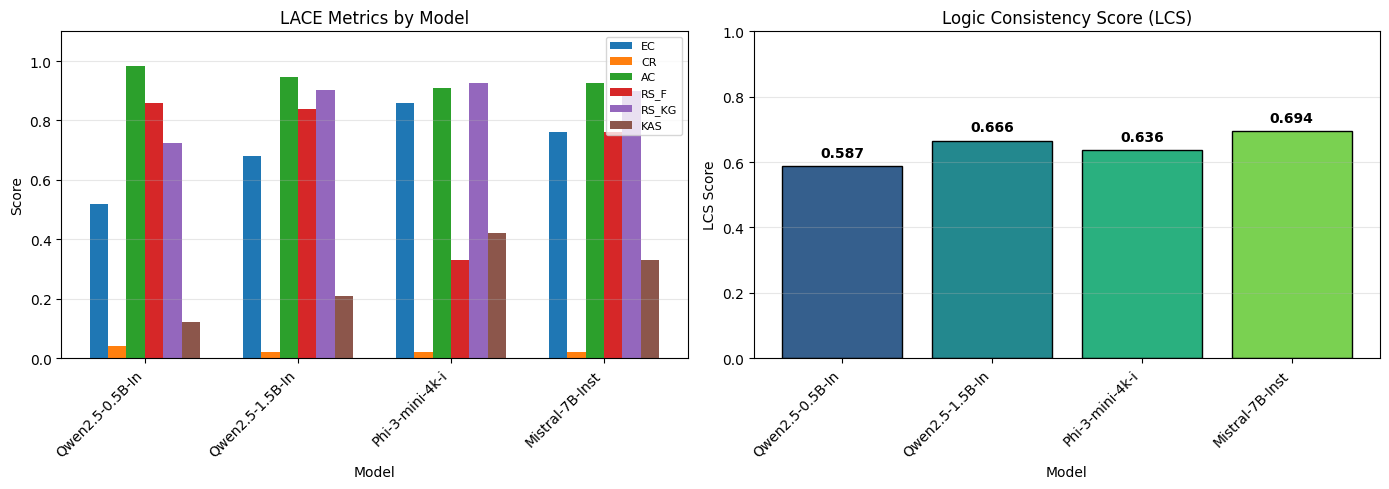


Visualization saved to lace_results.png


In [11]:
# =============================================================================
# Results Visualization
# =============================================================================
# This cell generates five publication-ready plots:
#   1. Grouped bar chart comparing all metrics across models
#   2. LCS score comparison bar chart
#   3. Heatmap of all metrics including LCS
#   4. Stacked bar chart showing weighted LCS contributions
#   5. Stacked bar chart showing unweighted LCS contributions
#
# All plots are saved as separate PNG files for use in reports and papers.
# =============================================================================


def generate_visualizations(results_df, lcs_weights):
    """
    Generate all visualization plots for LACE evaluation results.

    Args:
        results_df: DataFrame containing evaluation results with columns
                   for model names and all metric scores.
        lcs_weights: Dictionary mapping metric names to their weights
                    in the LCS formula.

    Returns:
        None. Saves five PNG files to the current directory.
    """
    # -------------------------------------------------------------------------
    # Setup common variables
    # -------------------------------------------------------------------------
    metrics = ["EC", "CR", "AC", "RS_F", "RS_KG", "KAS"]
    x_positions = np.arange(len(results_df))
    model_labels = [m.split("/")[-1][:15] for m in results_df["model"]]

    # =========================================================================
    # Plot 1: All Metrics Comparison (Grouped Bar Chart)
    # =========================================================================
    plt.figure(figsize=(10, 5))
    bar_width = 0.12

    for i, metric in enumerate(metrics):
        offset = (i - len(metrics) / 2 + 0.5) * bar_width
        plt.bar(x_positions + offset, results_df[metric], bar_width, label=metric)

    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("LACE Metrics by Model")
    plt.xticks(x_positions, model_labels, rotation=45, ha="right")
    plt.ylim(0, 1.1)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.savefig("lace_metrics_grouped.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: lace_metrics_grouped.png")

    # =========================================================================
    # Plot 2: LCS Score Comparison
    # =========================================================================
    plt.figure(figsize=(8, 5))

    colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(results_df)))
    bars = plt.bar(x_positions, results_df["LCS"], color=colors, edgecolor="black")

    plt.xlabel("Model")
    plt.ylabel("LCS Score")
    plt.title("Logic Consistency Score (LCS)")
    plt.xticks(x_positions, model_labels, rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, results_df["LCS"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{value:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.savefig("lace_lcs.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: lace_lcs.png")

    # =========================================================================
    # Plot 3: Heatmap of All Metrics
    # =========================================================================
    heat_cols = metrics + ["LCS"]
    heat_data = results_df[heat_cols].to_numpy(dtype=float)

    plt.figure(figsize=(10, 4))
    plt.imshow(heat_data, aspect="auto", cmap="RdYlGn")
    plt.colorbar(label="Score")

    plt.xticks(np.arange(len(heat_cols)), heat_cols, rotation=45, ha="right")
    plt.yticks(np.arange(len(model_labels)), model_labels)
    plt.title("LACE Metrics Heatmap")

    # Add value annotations
    for i in range(heat_data.shape[0]):
        for j in range(heat_data.shape[1]):
            plt.text(j, i, f"{heat_data[i, j]:.3f}",
                    ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.savefig("lace_heatmap.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: lace_heatmap.png")

    # =========================================================================
    # Plot 4: Weighted LCS Contribution Breakdown (Stacked Bar)
    # =========================================================================
    total_weight = sum(lcs_weights.values())

    # Calculate weighted contribution of each metric
    contributions = {
        "EC": (lcs_weights["ec"] * results_df["EC"].to_numpy()) / total_weight,
        "1-CR": (lcs_weights["cr"] * (1.0 - results_df["CR"].to_numpy())) / total_weight,
        "AC": (lcs_weights["ac"] * results_df["AC"].to_numpy()) / total_weight,
        "RS_F": (lcs_weights["rs_f"] * results_df["RS_F"].to_numpy()) / total_weight,
        "RS_KG": (lcs_weights["rs_kg"] * results_df["RS_KG"].to_numpy()) / total_weight,
        "KAS": (lcs_weights["kas"] * results_df["KAS"].to_numpy()) / total_weight,
    }

    plt.figure(figsize=(10, 5))
    bottom = np.zeros(len(results_df))

    for label, vals in contributions.items():
        plt.bar(x_positions, vals, bottom=bottom, label=label, edgecolor="black")
        bottom += vals

    # Add total labels
    for i, total in enumerate(bottom):
        plt.text(i, total + 0.01, f"{total:.3f}",
                ha="center", va="bottom", fontweight="bold")

    plt.xticks(x_positions, model_labels, rotation=45, ha="right")
    plt.ylim(0, max(bottom) * 1.15)
    plt.ylabel("Weighted Contribution to LCS")
    plt.title("LCS Component Breakdown (Weighted)")
    plt.grid(axis="y", alpha=0.3)
    plt.legend(fontsize=8, loc="upper left")

    plt.tight_layout()
    plt.savefig("lace_lcs_contributions_weighted.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: lace_lcs_contributions_weighted.png")

    # =========================================================================
    # Plot 5: Unweighted LCS Contribution Breakdown (Stacked Bar)
    # =========================================================================
    equal_weight = 1.0 / 6.0

    contributions_unweighted = {
        "EC": equal_weight * results_df["EC"].to_numpy(),
        "1-CR": equal_weight * (1.0 - results_df["CR"].to_numpy()),
        "AC": equal_weight * results_df["AC"].to_numpy(),
        "RS_F": equal_weight * results_df["RS_F"].to_numpy(),
        "RS_KG": equal_weight * results_df["RS_KG"].to_numpy(),
        "KAS": equal_weight * results_df["KAS"].to_numpy(),
    }

    plt.figure(figsize=(10, 5))
    bottom_u = np.zeros(len(results_df))

    for label, vals in contributions_unweighted.items():
        plt.bar(x_positions, vals, bottom=bottom_u, label=label, edgecolor="black")
        bottom_u += vals

    # Add total labels
    for i, total in enumerate(bottom_u):
        plt.text(i, total + 0.01, f"{total:.3f}",
                ha="center", va="bottom", fontweight="bold")

    plt.xticks(x_positions, model_labels, rotation=45, ha="right")
    plt.ylim(0, max(bottom_u) * 1.15)
    plt.ylabel("Contribution to LCS (Equal Weights)")
    plt.title("LCS Component Breakdown (Unweighted)")
    plt.grid(axis="y", alpha=0.3)
    plt.legend(fontsize=8, loc="upper left")

    plt.tight_layout()
    plt.savefig("lace_lcs_contributions_unweighted.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: lace_lcs_contributions_unweighted.png")


# -----------------------------------------------------------------------------
# Generate all visualizations
# -----------------------------------------------------------------------------
generate_visualizations(df, CONFIG.lcs_weights)

print("\nAll visualizations saved successfully")


## 11. Metric Interpretation

| Metric | Range | Interpretation |
|--------|-------|----------------|
| EC | [0, 1] | Higher is better - model outputs entail gold answers |
| CR | [0, 1] | Lower is better - model outputs do not contradict context |
| AC | [0, 1] | Higher is better - model gives consistent answers |
| RS_F | [0, 1] | Higher is better - correct logical reasoning |
| RS_KG | [0, 1] | Higher is better - accurate knowledge graph verbalization |
| KAS | [0, 1] | Higher is better - sensitive to counterfactual changes |
| LCS | [0, 1] | Higher is better - overall logic consistency |

### LCS Weighting Rationale

The weighted LCS formula emphasizes discriminative metrics:
- **EC, RS_F, KAS** (weight=2.0): These metrics show the most variation across model sizes
- **RS_KG** (weight=1.0): Moderate discrimination
- **CR, AC** (weight=0.5): Near-floor and near-ceiling respectively, less informative

In [12]:
# =============================================================================
# Cleanup
# =============================================================================
# Release GPU memory used by the NLI judge model.
# This should be run after evaluation is complete.
# =============================================================================

nli_judge.cleanup()
print("\nCleanup complete - GPU memory released")



Cleanup complete - GPU memory released
